# Illinois Gambling Analysis
> Using Hierarchical Linear Modeling to infer the relationship between video gambling terminals and casino tax revenue at the municipal level.

## Purpose

In this notebook I use hierarchical linear models to evaluate the relationship between the number of video gambling terminals within a municipality and the public funds that result from casino revenue while controlling for differences in population between communities. By using hierarchical models, as opposed to the standard Ordinary Least Squares method, I am able to infer the average impact that terminal count has on resulting tax revenue, and the variance that can be expected across communities. 

### Running the code

#### Virtual Environment

To ensure you have all required packages for this notebook, an environment.yml file has been provided [here]().
Follow the set-up instructions [here]() to create and activate the environment.

#### SQL or Pandas?

*TL;DR* Either is fine. The notebook can be run with or without the database.

>This notebook uses data that has been scraped from the [illinois gaming board website](https://www.igb.illinois.gov/) and inserted into a postgresql database. The code in the cell below checks if the database has been created. If so, the notebook will run using postgresql. If the database has not been creeated or if the database is empty, the data for this project have been provided as csv files. In this second case, the notebook will handle all data manipulations in pandas. 
You may choose to run the scraping and database creation code or not. Each code cell begins with an if check to determine if the database is created and then activate the sql or pandas code accordingly.

------

#### Data Collection

The code used for collecting the gambling data can be found [here]()

The code used for collecting census variables can be found [here]()

------

In [28]:
query('select * from video_gambling;').to_csv('../data/video_gambling.csv')

In [126]:
# Notebook Imports
import os
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import string
from collections import defaultdict
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import geopandas as gpd
%matplotlib inline

conn = psycopg2.connect(dbname="illinois_gambling")

def query(query):
    return pd.read_sql(query, conn)

## Background

Video gambling was legalized by the state of Illinois in 2009, with the first machines activated in September of 2012. Since then the number of towns that have installed video gambling machines has increased every year.
> **Note:** All video gambling activities were suspended from April 2020-June 2020 to mitigate transmission of COVID19. While data for 2020 has been reported by the [Illinois Gaming Board](https://www.igb.illinois.gov/) these data require further clarification by the Illinois Gaming Board before they can be confidently analyzed. Because of this, 2020 data  is largely excluded from this analysis and excluded entirely from the models developed in this notebook. 

In [162]:
query_results.loc[2013:2014]

,num_of_towns
year,
2013,737
2014,825


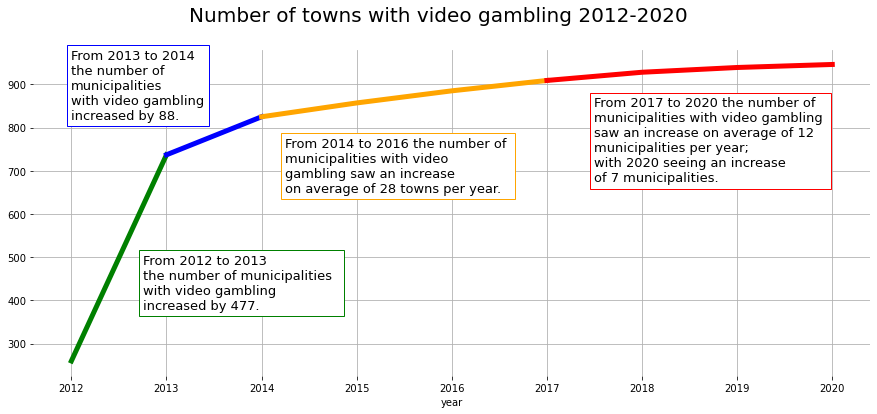

In [164]:
### Visualization Code
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              count(DISTINCT municipality.name) as num_of_towns
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''

query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.loc[:2013].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='green')
query_results.loc[2013:2014].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='blue')
query_results.loc[2014:2017].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='orange')
query_results.loc[2017:].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='red')
# axes[0].set_yticks(query_results.num_of_towns)
fig.suptitle('Number of towns with video gambling 2012-2020', fontsize=20)
ax.grid()

ax.set_frame_on(False)

first_annotation = ax.text(2012.75, 380, 
f'''From 2012 to 2013 
the number of municipalities  
with video gambling 
increased by\
 {int(query_results.loc[[2012,2013]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
first_annotation.set_bbox(dict(facecolor='white', edgecolor='green'))

second_annotation = ax.text(2012, 820, 
f'''From 2013 to 2014\nthe number of
municipalities
with video gambling\nincreased by\
 {int(query_results.loc[[2013,2014]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
second_annotation.set_bbox(dict(facecolor='white', edgecolor='blue'))

third_annotation = ax.text(2014.25, 650, f'''\
From 2014 to 2016 the number of 
municipalities with video 
gambling saw an increase\non average of \
{int(round(query_results.loc[2014:2017].num_of_towns.diff().mean()))} \
towns per year.''', dict(size=13))
third_annotation.set_bbox(dict(facecolor='white', edgecolor='orange'))

fourth_annotation = ax.text(2017.5, 675, f'''\
From 2017 to 2020 the number of
municipalities with video gambling 
saw an increase on average of \
{int(round(query_results.loc[2017:].num_of_towns.diff().mean()))} 
municipalities per year; 
with 2020 seeing an increase 
of {int(round(query_results.loc[2017:].num_of_towns.diff().loc[2020]))} municipalities.''', dict(size=13))
fourth_annotation.set_bbox(dict(facecolor='white', edgecolor='red'))

fig_path = os.path.join(os.pardir, 'static', 'video_gambling_growth_timeline.png')
fig.savefig(fig_path)

**Prior to the legalization of video gambling**, if an Illinois residents had wanted to gamble their only option was to travel to one of the few municipalities home to a casino.

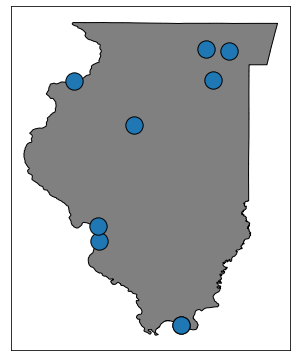

In [181]:
# Visualization Code 

q = '''SELECT DISTINCT municipality, latitude, longitude
        FROM casino;'''

towns_with_casinos = query(q)
shape_path = os.path.join(os.pardir, 'data', 'shapefiles', 'state', 'tl_2019_us_state.shp')
us = gpd.read_file(shape_path)
illinois = us[us.STUSPS == 'IL']

towns_with_casinos['latitude'] = towns_with_casinos['latitude'].astype(float)
towns_with_casinos['longitude'] = towns_with_casinos['longitude'].astype(float)

fig, ax = plt.subplots(figsize=(5, 8)) 
illinois.plot(ax=ax, color='grey', lw=1, edgecolors='black')

x, y = towns_with_casinos.longitude, towns_with_casinos.latitude
ax.scatter(x,y, edgecolors='black', s=300)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig_path = os.path.join(os.pardir, 'static', 'casino_locations.png')
fig.savefig(fig_path, bbox_inches='tight')
plt.show()

**However**, since activation of video gambling in 2012, access to gambling facilities have become widely distributed throughout the state.

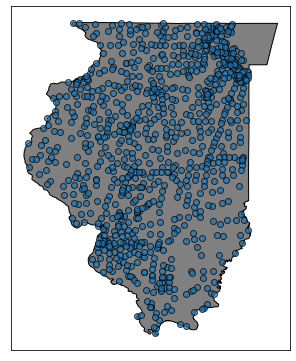

In [180]:
# Visualization Code
q = '''SELECT name, latitude, longitude, terminal_count
        FROM (
        SELECT SUM(terminal_count) as terminal_count, municipality AS name
        FROM video_gambling
        WHERE DATE_PART('year', video_gambling.date) = 2019
        AND DATE_PART('month', video_gambling.date) = 11
        GROUP BY municipality) subquery
        INNER JOIN municipality
        USING(name);
        '''
        
results = query(q)
results['latitude'] = results.latitude.astype(float)
results['longitude'] = results.longitude.astype(float)

fig, ax = plt.subplots(figsize=(5, 8)) 
illinois.plot(ax=ax, color='grey', lw=1, edgecolors='black')

x, y = results.longitude, results.latitude
ax.scatter(x,y, edgecolors='black',  alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig_path = os.path.join(os.pardir, 'static', 'terminal_locations_2019.png')
fig.savefig(fig_path,bbox_inches='tight')
plt.show()

During this same time, **Illinois has also seen a near consistent decline in casino revenue.**

In [14]:
# Data Code
video = """SELECT CONCAT(
                      CAST(CAST(DATE_PART('YEAR', video.date) AS INTEGER) AS TEXT),
                      '-',
                      CAST(CAST(DATE_PART('MONTH', video.date) AS INTEGER) AS TEXT)) AS date,
              video.municipality,
              SUM(video.terminal_count) AS terminal_count,
              SUM(video.amount_played) - SUM(video.amount_won) AS video_agr,
              SUM(video.municipality_share) AS video_local_share, 
              SUM(video.state_share) AS video_state_share
              FROM video_gambling video
              WHERE video.municipality IN (
              SELECT casino.municipality
              FROM casino)
              GROUP BY video.municipality, 
                       DATE_PART('YEAR', video.date), 
                       DATE_PART('MONTH', video.date)"""

casino = '''SELECT CONCAT(
                      CAST(CAST(DATE_PART('YEAR', casino.date) AS INTEGER) AS TEXT),
                      '-',
                      CAST(CAST(DATE_PART('MONTH', casino.date) AS INTEGER) AS TEXT)) AS date,
                   SUM(casino.adjusted_gross_receipt) AS casino_agr,
                   SUM(casino.admissions) AS admissions,
                   SUM(casino.state_share) AS casino_state_share,
                   SUM(casino.local_share) AS casino_local_share,
                   casino.municipality
                   FROM casino
                   GROUP BY casino.municipality, DATE_PART('YEAR', casino.date), DATE_PART('MONTH', casino.date);'''

yearly_demographics = f'''SELECT demo.year,
                        demo.municipality,
                        SUM(demo."B01003_001E") as population
                        FROM demographics demo
                        GROUP BY demo.year, demo.municipality'''

video_demographics = f"""SELECT demo."B01003_001E"as population,
                                demo.year,
                                demo.municipality 
                         FROM demographics demo
                   WHERE demo.year IN (
                   SELECT DATE_PART('year', video.date) as year
                   FROM video_gambling video) 
                   AND demo.municipality IN (
                   SELECT DISTINCT municipality FROM casino);"""

df = query(video).merge(query(casino), on=['municipality', 'date'])
demographics = query(yearly_demographics)

df['casino_public_funds'] = df.casino_local_share + df.casino_state_share
df['video_public_funds'] = df.video_local_share + df.video_state_share
df.date = pd.to_datetime(df.date, format='%Y-%m')
df.set_index('date', inplace=True)
df = df.loc[:'2019']
yearly = df.groupby([pd.Grouper(freq='Y'), 'municipality']).sum().reset_index().set_index('date')
yearly['year'] = [date.year for date in yearly.index]
yearly = yearly.merge(demographics, on=['year', 'municipality'], right_index=True)
df['year'] = [x.year for x in df.index]
df = df.merge(query(video_demographics), on=['municipality', 'year'], right_index=True)

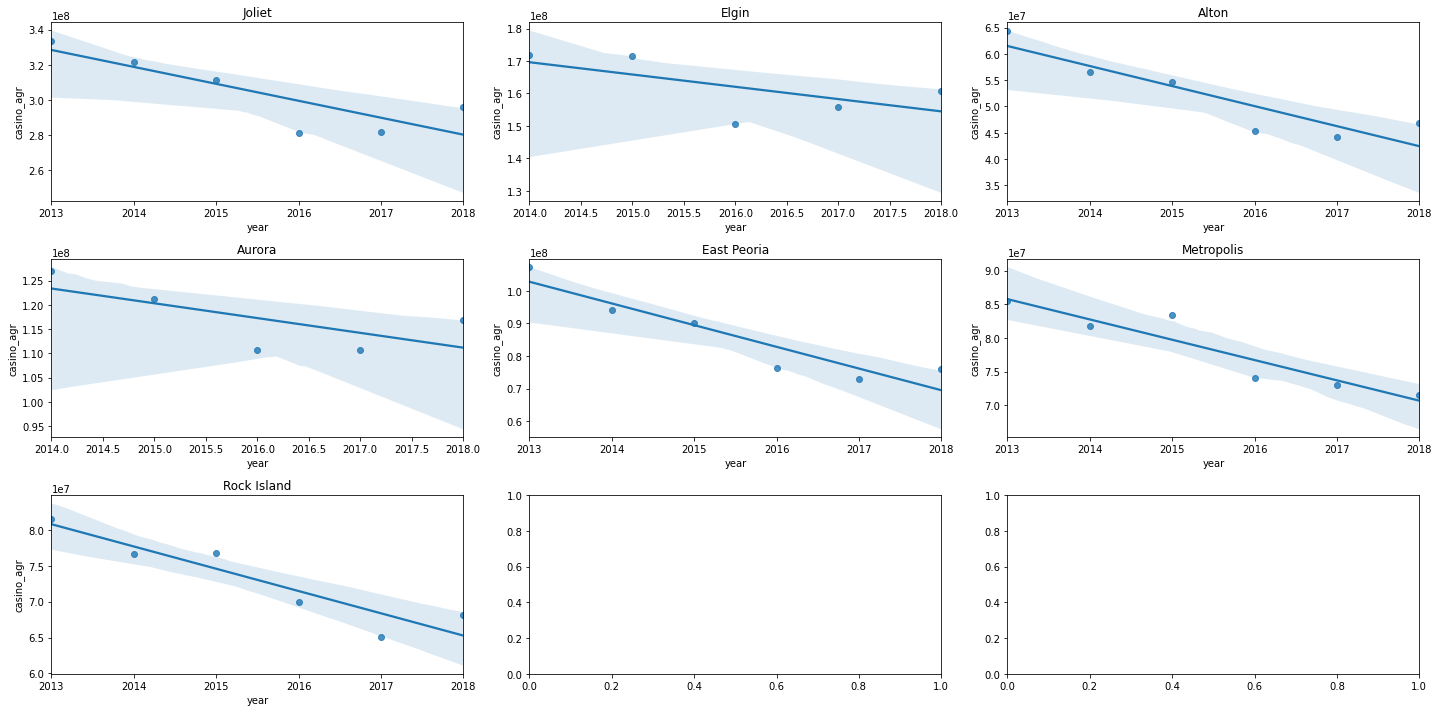

In [174]:
# Visualization Code

def subplot_map(idx, columns):
    return (idx//columns, idx%columns)

figure, axes = plt.subplots(3,3, figsize=(20,10))
casinos = df.municipality.unique()
for idx in range(len(casinos)):
    frame = yearly[yearly.municipality == casinos[idx]][['casino_agr', 'year']].iloc[1:]
    row, column = subplot_map(idx, 3)
    sns.regplot(x=frame.year, y=frame.casino_agr, ax=axes[row,column])
    axes[row, column].set_title(casinos[idx])
fig_path = os.path.join(os.pardir, 'static', 'casino_decline.png')
figure.savefig(fig_path)
figure.tight_layout()

Given the growth that has occurred for video gambling products, increased scrutiny was likely inevitable, but due to the decline in Casino revenue, the differing tax rates between video and casino gambling has been frequently debated by journalists, voters, and legislators.

### Tax Breakdown

**TLDR;**
> **Casino gambling tax rates increase as revenue increases. The tax rate for video gambling is fixed.**

"*Wagering Tax Effective July 1, 2020, the wagering tax is as follows:*

<u><i>All gambling games, other than table games:</i></u>
- *15% of AGR up to and including \$25 million*
- *22.5% of AGR in excess of 25 million but not exceeding 50 million*
- *27.5% of AGR in excess of 50 million but not exceeding 75 million*
- *32.5% of AGR in excess of 75 million but not exceeding 100 million*
- *37.5% of AGR in excess of 100 million but not exceeding 150 million*
- *45% of AGR in excess of 150 million but not exceeding 200 million*
- *50% of AGR in excess of 200 million

<u><i>All table games:</i></u>
- *15% of AGR up to and including 25 million*
- *20% of AGR in excess of 25 million"*
> -[Illinois Gaming Board](https://www.igb.illinois.gov/CasinoFAQ.aspx#:~:text=The%20Illinois%20Gambling%20Act%20imposes,and%20a%20tax%20on%20admissions.&text=The%20admissions%20tax%20was%20increased,person%20to%20%243%20a%20person.)

/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Users/joel/opt/anaconda3/envs/mlearn/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



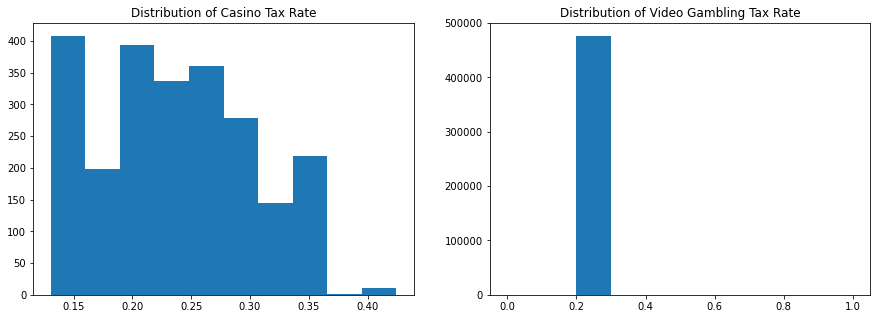

In [19]:
# Visualization Code

fig, axes = plt.subplots(1,2, figsize=(15,5))

q = """SELECT state_share, local_share, adjusted_gross_receipt, DATE_PART('year', date) as year
           FROM casino"""

casino_tax_rate = query(q)
public_dollars = (casino_tax_rate.local_share + casino_tax_rate.state_share)
casino_tax_rate['tax_rate'] = public_dollars/(public_dollars + casino_tax_rate.adjusted_gross_receipt)
axes[0].hist(casino_tax_rate.tax_rate)
axes[0].set_title('Distribution of Casino Tax Rate')


q = """SELECT state_share, municipality_share, net_terminal_income
       FROM video_gambling;"""

video_tax_rate = query(q)
public_dollars = video_tax_rate.state_share + video_tax_rate.municipality_share
video_tax_rate['rate'] = public_dollars/(video_tax_rate.net_terminal_income + public_dollars)

plt.title('Distribution of Video Gambling Tax Rate')
axes[1].hist(video_tax_rate.rate);

<u>Ultimately, the debate tends to go as followed:</u>

**Person A:** "Video gambling is cutting into casino revenue, and casino revenue is taxed at a greater rate than video gambling so video gambling is bad for my community!"

**Person B:** "Video gambling has a fixed tax rate, but casino gambling is frequently taxed at half the rate of video gambling, so video gambling is good for my community!"

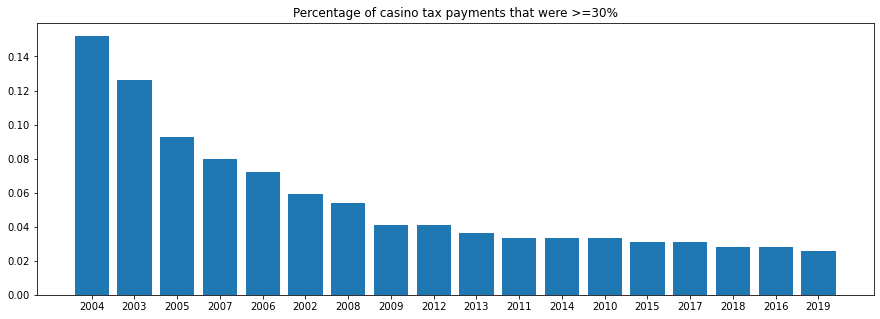

In [20]:
# Visualization Code
series = casino_tax_rate[casino_tax_rate.tax_rate >= .3].year.value_counts(normalize=True)
plt.figure(figsize=(15,5))
plt.bar([str(int(x)) for x in series.index], series.values)
plt.title('Percentage of casino tax payments that were >=30%');

While it is true that casino revenue is in decline, in the case of tax rates higher than that of video gambling, this decline has been consistent since 2003. Because the first video gambling terminals did not go live until 2012, it is not accurate to say the introduction of video gambling is the sole driver of the decline in higher tax payments from casinos.

This however is neither evidence in support or against the suggestion that video gambling leads to less public funds. **So does it?** To determine this we must ask ourselves, *what is the relationship between video gambling and casino tax revenue? On average, what happens to casino tax revenue when new video gambling terminals are introduced to a community?*

These are questions for which linear regression is well suited. But for this problem OLS which assumes independence across observation would ignore the inherent correlation that exists within municipalities. The mean and standard deviations of terminal counts and tax revenue in one municipality are likely to differ drastically from municipalities with higher populations. For this reason, I will use multi level linear regression which controls for intercluster correlation and allows the adding of random intercepts and slopes for relevant parameters. Ultimately this gives me the ability to account for multiple stratifications of dependence within my model.

## The data

The data for this project consists of casino and video gambling monthly reports and census data that was collected for each municipality using the 5 Year American Community Survey (ACS). The monthly reports were collected with a selenium web scraper and all data was inserted into a postgresql `illinois_gambling` database. 

To review the scraping code, a jupyter notebook has been provided as documentation, and the source code can be found [here](../src/scrape.py)

In [71]:
df.head()

,municipality,terminal_count,video_agr,video_local_share,video_state_share,casino_agr,admissions,casino_state_share,casino_local_share,casino_public_funds,video_public_funds
date,,,,,,,,,,,
2013-01-01,Alton,28.0,89280.52,4464.08,22320.40,5283000.0,63037.0,654000.0,327000.0,981000.0,26784.48
2013-02-01,Alton,38.0,98998.30,4949.90,24749.26,5640702.0,65222.0,694514.0,347257.0,1041771.0,29699.16
2013-03-01,Alton,64.0,123117.68,6162.90,30772.72,6618381.0,71683.0,805204.0,402602.0,1207806.0,36935.62
2013-04-01,Alton,82.0,196128.58,9806.54,49032.48,5937582.0,64442.0,722642.0,361321.0,1083963.0,58839.02
2013-05-01,Alton,96.0,223333.28,11166.58,55833.16,5727268.0,66369.0,1020979.0,352732.0,1373711.0,66999.74
